In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression

In [4]:
data = pd.read_csv("BostonHousing.csv")
# Check the columns of the dataset to understand any discrepancies
print("Columns in the dataset:")
print(data.columns)


Columns in the dataset:
Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'b', 'lstat', 'medv'],
      dtype='object')


In [5]:

features = ['crim', 'zn', 'indus', 'nox', 'rm', 'age', 'dis', 'tax', 'ptratio', 'lstat']
target = 'medv'

# Selecting the feature columns and target column
X = data[features]
y = data[target]



In [6]:
# Data Exploration
print("Initial Data Summary:")
print(data.describe())


Initial Data Summary:
             crim          zn       indus        chas         nox          rm  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  501.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284341   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.705587   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.884000   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208000   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.625000   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              age         dis         rad         tax     ptratio           b  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std  

In [7]:
# Check and handle missing values by replacing with mean
X = X.fillna(X.mean())


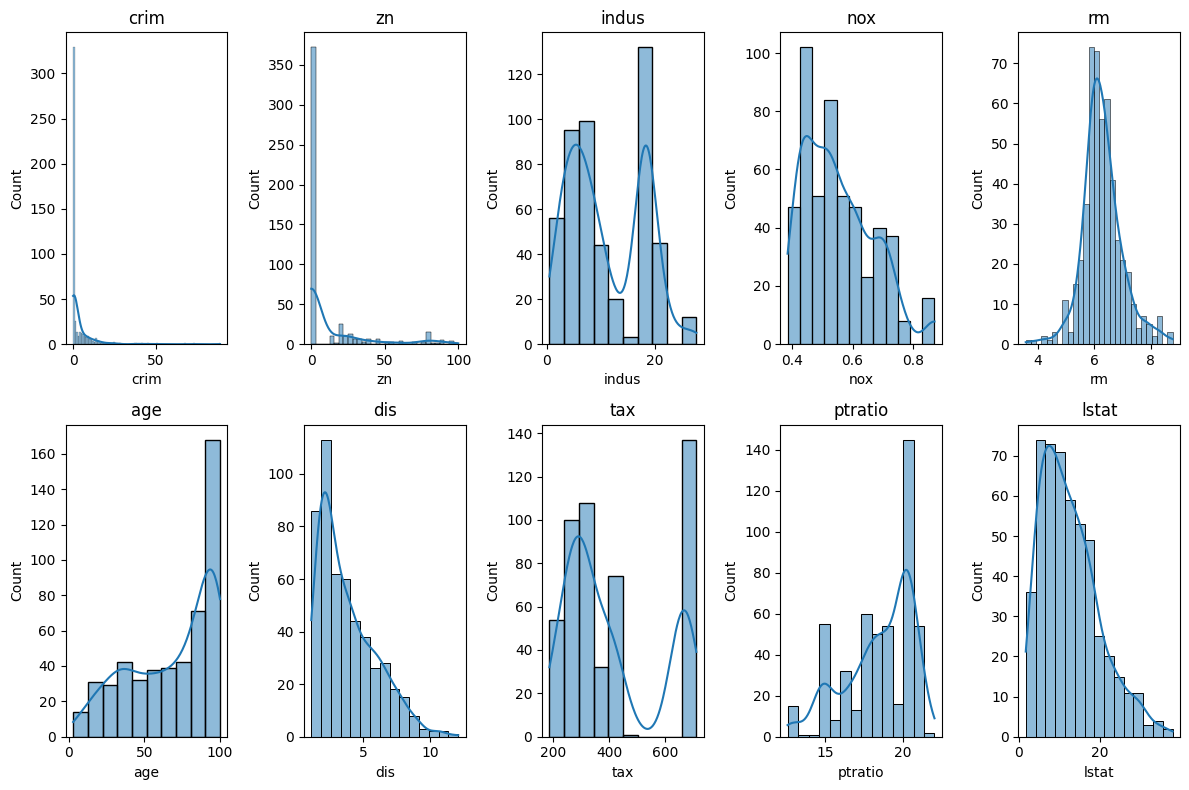

In [8]:
# Plot feature distributions to check for outliers
plt.figure(figsize=(12, 8))
for i, col in enumerate(features):
    plt.subplot(2, 5, i + 1)
    sns.histplot(data[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

In [9]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
# 1. Low Variance Filter
low_variance_filter = VarianceThreshold(threshold=0.1)
X_low_variance = low_variance_filter.fit_transform(X_scaled)
low_variance_features = X.columns[low_variance_filter.get_support()]
print("\nSelected features using Low Variance Filter:")
print(list(low_variance_features))



Selected features using Low Variance Filter:
['crim', 'zn', 'indus', 'nox', 'rm', 'age', 'dis', 'tax', 'ptratio', 'lstat']


In [12]:
# 2. Principal Component Analysis (PCA)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"\nNumber of components selected by PCA to retain 95% variance: {X_pca.shape[1]}")



Number of components selected by PCA to retain 95% variance: 8


In [ ]:
# 3. High Correlation Filter (HCF)
# Correlation matrix and filter highly correlated features
cor_matrix = pd.DataFrame(X_scaled, columns=features).corr().abs()
plt.figure(figsize=(10, 8))
sns.heatmap(cor_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

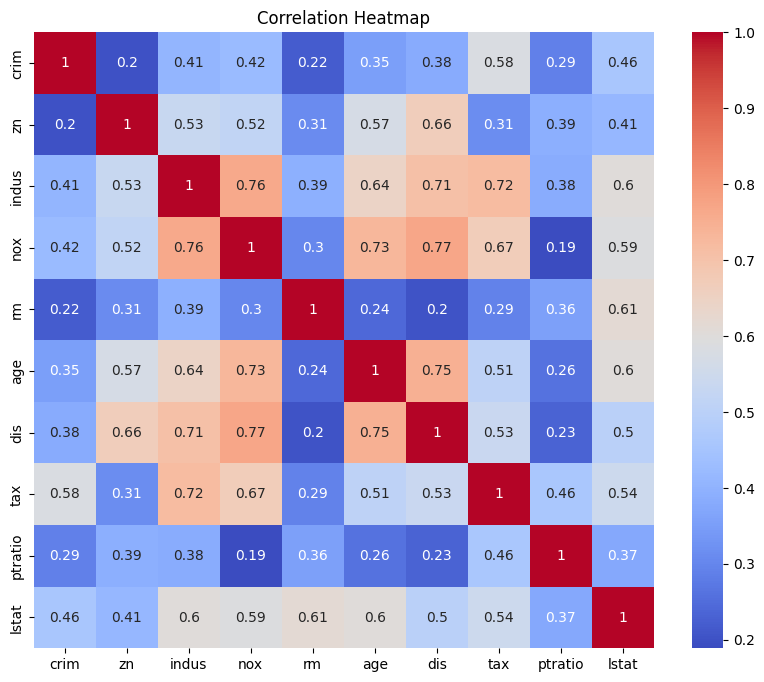

In [15]:
# Remove features with high correlation (threshold > 0.8)
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper_tri.columns if any(upper_tri[col] > 0.8)]
X_high_corr = X_scaled[:, ~X.columns.isin(to_drop)]
print("\nSelected features after High Correlation Filter:")
print(list(X.columns[~X.columns.isin(to_drop)]))



Selected features after High Correlation Filter:
['crim', 'zn', 'indus', 'nox', 'rm', 'age', 'dis', 'tax', 'ptratio', 'lstat']


In [20]:
# 4. Model Training and Evaluation
# Helper function for model training and evaluation
def train_evaluate_model(X_train, X_test, y_train, y_test, technique_name):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)
    print(f"\n{technique_name} Model Performance:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"R-squared: {r2:.2f}")
    print(f"Adjusted R-squared: {adj_r2:.2f}")
    return mse, mae, r2, adj_r2


In [21]:
# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [22]:
# Original Model without feature selection
print("\n--- Model without Feature Selection ---")
mse_all, mae_all, r2_all, adj_r2_all = train_evaluate_model(X_train, X_test, y_train, y_test, "Original Features")



--- Model without Feature Selection ---

Original Features Model Performance:
Mean Squared Error: 25.43
Mean Absolute Error: 3.33
R-squared: 0.65
Adjusted R-squared: 0.62


In [23]:
# Low Variance Filter Model
X_train_lv, X_test_lv = X_train[:, low_variance_filter.get_support()], X_test[:, low_variance_filter.get_support()]
mse_lv, mae_lv, r2_lv, adj_r2_lv = train_evaluate_model(X_train_lv, X_test_lv, y_train, y_test, "Low Variance Filter")


Low Variance Filter Model Performance:
Mean Squared Error: 25.43
Mean Absolute Error: 3.33
R-squared: 0.65
Adjusted R-squared: 0.62


In [24]:
# PCA Model
mse_pca, mae_pca, r2_pca, adj_r2_pca = train_evaluate_model(X_pca[:len(y_train)], X_pca[len(y_train):], y_train, y_test, "PCA")



PCA Model Performance:
Mean Squared Error: 78.16
Mean Absolute Error: 6.48
R-squared: -0.07
Adjusted R-squared: -0.16


In [25]:
# High Correlation Filter Model
X_train_hcf, X_test_hcf = X_train[:, ~X.columns.isin(to_drop)], X_test[:, ~X.columns.isin(to_drop)]
mse_hcf, mae_hcf, r2_hcf, adj_r2_hcf = train_evaluate_model(X_train_hcf, X_test_hcf, y_train, y_test, "High Correlation Filter")



High Correlation Filter Model Performance:
Mean Squared Error: 25.43
Mean Absolute Error: 3.33
R-squared: 0.65
Adjusted R-squared: 0.62


In [27]:
# Comparison Table
comparison_table = pd.DataFrame({
    "Technique": ["Original", "Low Variance Filter", "PCA", "High Correlation Filter"],
    "MSE": [mse_all, mse_lv, mse_pca, mse_hcf],
    "MAE": [mae_all, mae_lv, mae_pca, mae_hcf],
    "R2": [r2_all, r2_lv, r2_pca, r2_hcf],
    "Adjusted R2": [adj_r2_all, adj_r2_lv, adj_r2_pca, adj_r2_hcf]
})
print("\nComparison of Model Performances with Different Feature Selection Techniques:")
print(comparison_table)



Comparison of Model Performances with Different Feature Selection Techniques:
                 Technique        MSE       MAE        R2  Adjusted R2
0                 Original  25.430352  3.326760  0.653225     0.615117
1      Low Variance Filter  25.430352  3.326760  0.653225     0.615117
2                      PCA  78.163650  6.475608 -0.065861    -0.157548
3  High Correlation Filter  25.430352  3.326760  0.653225     0.615117


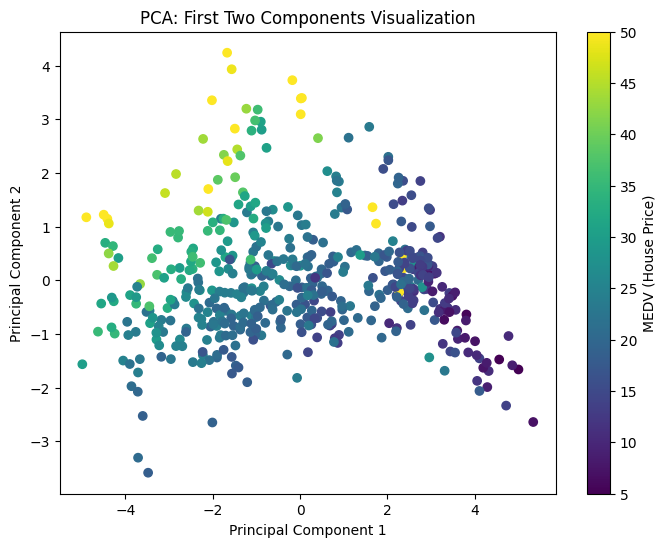

In [28]:
# Visualization of PCA Components
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.colorbar(label="MEDV (House Price)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA: First Two Components Visualization")
plt.show()